In [1]:
!pip install tensorflow

In [2]:
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb
# Import KerasRegressor directly from tensorflow
from tensorflow import keras # Import keras directly
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor # Assuming TensorFlow 2.0 or later # This is the old import and is likely outdated.
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential # Import Sequential from tensorflow.keras.models
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN # Import layers from tensorflow.keras.layers
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv(
    "/content/drive/MyDrive/ML & Deep Learning/Airquality/gams_preprocessed_hourly.csv",
    parse_dates=["ts"],
    index_col="ts",
)

In [5]:
data.head()

,co2,humidity,pm10,pm25,temperature,voc,Month,Week,Day,Day_of_week,...,pm10_window,pm25_window,temperature_window,voc_window,Month_sin,Month_cos,Hour_sin,Hour_cos,Day_sin,Day_cos
ts,,,,,,,,,,,,,,,,,,,,,
2016-11-22 00:00:00,0.125142,0.681239,0.022233,0.033495,0.592737,0.000287,11,47,22,1,...,0.026882,0.041626,0.624210,0.000309,-0.5,0.866025,0.000000,1.000000,-0.968077,-0.250653
2016-11-22 01:00:00,0.159592,0.659048,0.006791,0.007556,0.613171,0.000258,11,47,22,1,...,0.028853,0.044576,0.607663,0.000319,-0.5,0.866025,0.269797,0.962917,-0.968077,-0.250653
2016-11-22 02:00:00,0.316681,0.633366,0.008445,0.009361,0.645052,0.000405,11,47,22,1,...,0.023795,0.036160,0.604318,0.000239,-0.5,0.866025,0.519584,0.854419,-0.968077,-0.250653
2016-11-22 03:00:00,0.443831,0.611913,0.018425,0.024901,0.666608,0.000563,11,47,22,1,...,0.012489,0.016804,0.616987,0.000317,-0.5,0.866025,0.730836,0.682553,-0.968077,-0.250653
2016-11-22 04:00:00,0.532989,0.624371,0.025304,0.033161,0.695313,0.011083,11,47,22,1,...,0.011220,0.013939,0.641610,0.000409,-0.5,0.866025,0.887885,0.460065,-0.968077,-0.250653


# Split into train, test and validation
We will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I will split based on time. We leave the most recent data as test set.

In [6]:
# Verify the minimum and maximum dates in the dataset
min_date, max_date = data.index.min(), data.index.max()
print(f"Date range in data: {min_date} to {max_date}")

Date range in data: 2016-11-22 00:00:00 to 2017-03-28 09:00:00


In [7]:
# Define split dates
train_end_date = "2017-01-01"  # End date for the train set
val_end_date = "2017-03-01"    # End date for the validation set

In [8]:
# Calculate split indices based on 80%, 10%, and 10% proportions
train_size = int(len(data) * 0.8)
validation_size = int(len(data) * 0.1)

In [9]:
# Split the data chronologically
X_train = data.iloc[:train_size]                                      # First 80% for training
X_validation = data.iloc[train_size:train_size + validation_size]     # Next 10% for validation
X_test = data.iloc[train_size + validation_size:]                     # Remaining 10% for test

In [10]:
# Print the shapes to confirm
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_validation.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2332, 48)
Validation set shape: (291, 48)
Test set shape: (292, 48)


In [11]:
# Define target variable for each set
y_train = X_train["co2"].copy()
y_validation = X_validation["co2"].copy()
y_test = X_test["co2"].copy()

# Remove the target column from the predictors in each set
X_train = X_train.drop("co2", axis=1)
X_validation = X_validation.drop("co2", axis=1)
X_test = X_test.drop("co2", axis=1)

# Check the shapes to confirm
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape, "| y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)

X_train shape: (2332, 47) | y_train shape: (2332,)
X_validation shape: (291, 47) | y_validation shape: (291,)
X_test shape: (292, 47) | y_test shape: (292,)


In [12]:
p = ['co2', 'humidity', 'pm10', 'pm25', 'temperature', 'voc']

def return_train_data(data, feature):
    # Calculate indices for 80-10-10 split
    train_size = int(len(data) * 0.8)
    validation_size = int(len(data) * 0.1)

    # Split the data chronologically
    X_train = data.iloc[:train_size]
    X_validation = data.iloc[train_size:train_size + validation_size]
    X_test = data.iloc[train_size + validation_size:]

    # Define target variable for each set
    y_train = X_train[feature].copy()
    y_validation = X_validation[feature].copy()
    y_test = X_test[feature].copy()

    # Remove the target column from predictors in each set
    X_train = X_train.drop(feature, axis=1)
    X_validation = X_validation.drop(feature, axis=1)
    X_test = X_test.drop(feature, axis=1)

    return X_train, y_train, X_validation, y_validation, X_test, y_test, feature

**LION optimizer for LSTM**

In [13]:
pip install scikeras

In [16]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 50.7 MB/s eta 0:00:00


Processing feature: co2
Set parameter LogToConsole to value 0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0583
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0119
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0066
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoc

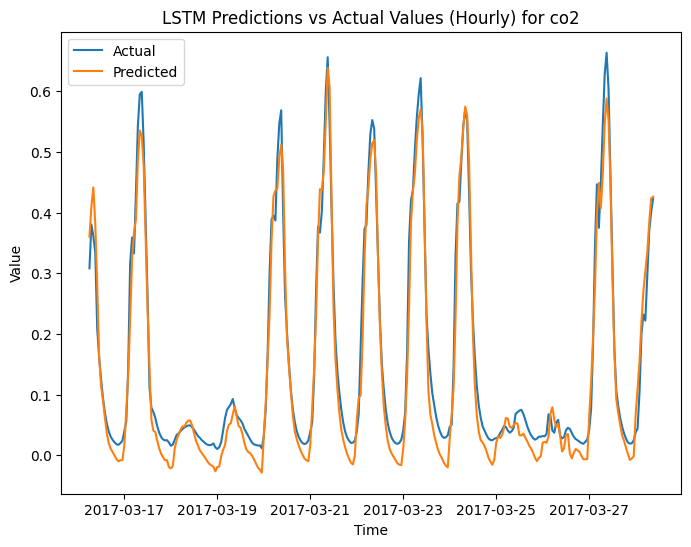

LSTM Training MSE: 0.000824
LSTM Training MAPE: 0.444172%
LSTM Validation MSE: 0.001050
LSTM Validation MAPE: 0.659844%
LSTM Testing MSE: 0.001218
LSTM Testing MAPE: 0.556240%
Processing feature: humidity
Set parameter LogToConsole to value 0
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1190
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0457e-04
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3101e-04
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4858e-04
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9192e-04
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2936

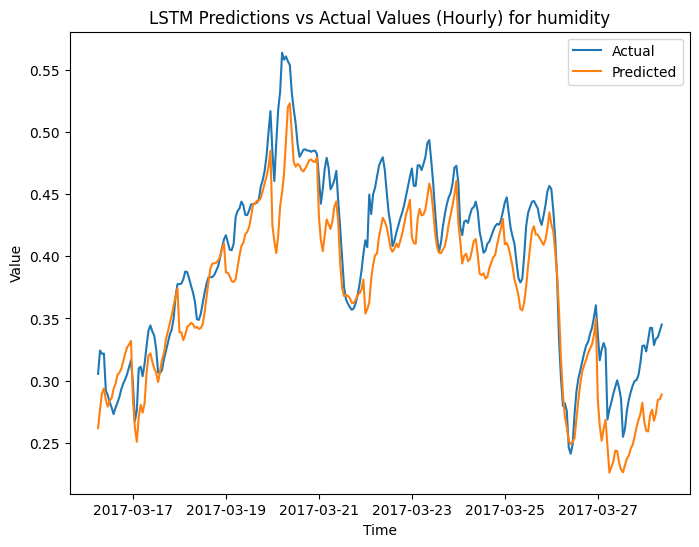

LSTM Training MSE: 0.000168
LSTM Training MAPE: 0.034923%
LSTM Validation MSE: 0.000895
LSTM Validation MAPE: 0.073096%
LSTM Testing MSE: 0.001129
LSTM Testing MAPE: 0.070027%
Processing feature: pm10
Set parameter LogToConsole to value 0
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0688
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0100
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4093e-04
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3327e-04
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3887e-04
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1615e-04
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6407e-04
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7125e-04
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0000e-04
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

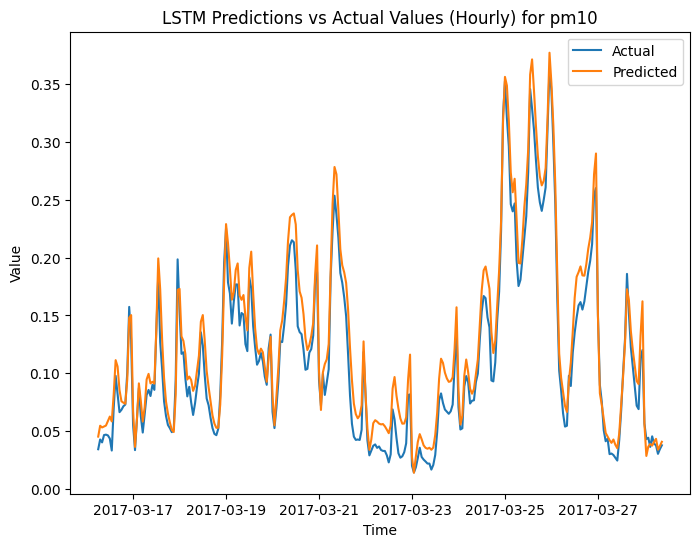

LSTM Training MSE: 0.000069
LSTM Training MAPE: 0.074406%
LSTM Validation MSE: 0.000161
LSTM Validation MAPE: 0.118949%
LSTM Testing MSE: 0.000380
LSTM Testing MAPE: 0.217522%
Processing feature: pm25
Set parameter LogToConsole to value 0
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0514
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 16/50
19/

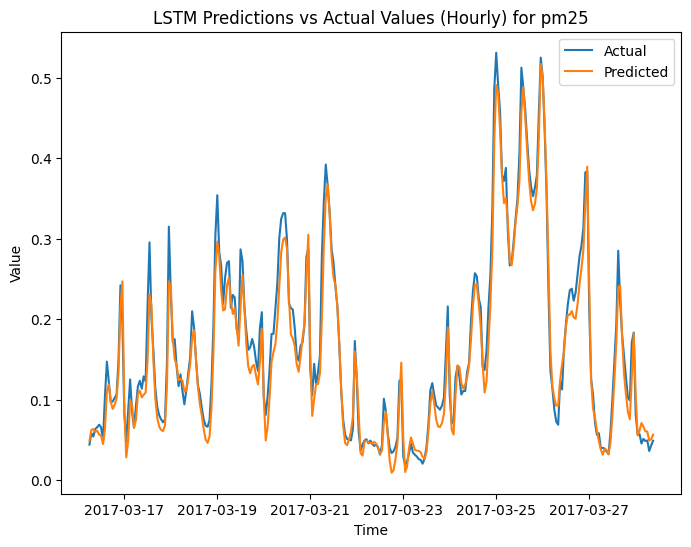

LSTM Training MSE: 0.000290
LSTM Training MAPE: 0.106762%
LSTM Validation MSE: 0.000513
LSTM Validation MAPE: 0.135444%
LSTM Testing MSE: 0.000521
LSTM Testing MAPE: 0.134128%
Processing feature: temperature
Set parameter LogToConsole to value 0
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0948
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0056
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 16/50
19/

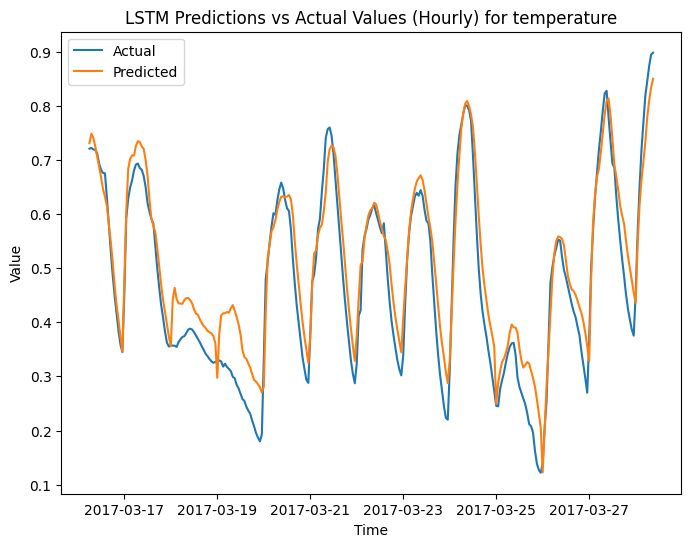

LSTM Training MSE: 0.000943
LSTM Training MAPE: 0.050397%
LSTM Validation MSE: 0.001673
LSTM Validation MAPE: 0.057659%
LSTM Testing MSE: 0.003231
LSTM Testing MAPE: 0.134874%
Processing feature: voc
Set parameter LogToConsole to value 0
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1023
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0090
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9973e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4868e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6104e-04
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7039e-04
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2638e-04
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3912e-04
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6426e-04
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0249e-04
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5763e-04
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms

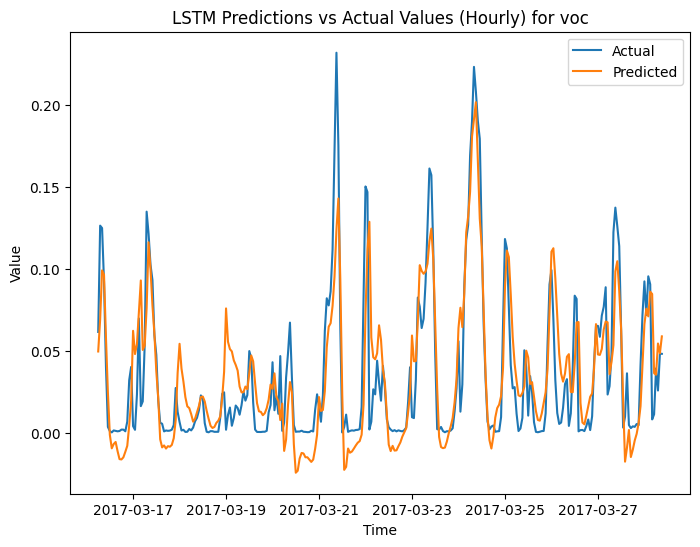

LSTM Training MSE: 0.000381
LSTM Training MAPE: 14763322381.815157%
LSTM Validation MSE: 0.000790
LSTM Validation MAPE: 8.594000%
LSTM Testing MSE: 0.000693
LSTM Testing MAPE: 4.501127%
Results written to results.json


In [18]:
import gurobipy as gp
from gurobipy import GRB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json

def lstm_regression_with_gurobi(X_train, y_train, X_validation, y_validation, X_test, y_test, feature):
    # Reshape data for LSTM
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_validation = X_validation.values.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define hyperparameter search space
    units_options = [256, 512, 1024]
    batch_size_options = [128, 256, 512]
    learning_rate_options = [0.001, 0.01]
    epochs_options = [50, 100]

    # Initialize Gurobi model
    model = gp.Model("LSTM_Optimizer")
    model.Params.LogToConsole = 0  # Disable Gurobi output

    # Decision variables
    units = model.addVar(vtype=GRB.CONTINUOUS, name="units")
    batch_size = model.addVar(vtype=GRB.CONTINUOUS, name="batch_size")
    learning_rate = model.addVar(vtype=GRB.CONTINUOUS, name="learning_rate")
    epochs = model.addVar(vtype=GRB.CONTINUOUS, name="epochs")

    # Objective: Minimize validation MSE (simplified as a placeholder for real objectives)
    model.setObjective(units + batch_size + epochs, GRB.MINIMIZE)

    # Add constraints to restrict to the nearest valid options
    model.addConstr(units >= min(units_options))
    model.addConstr(units <= max(units_options))
    model.addConstr(batch_size >= min(batch_size_options))
    model.addConstr(batch_size <= max(batch_size_options))
    model.addConstr(learning_rate >= min(learning_rate_options))
    model.addConstr(learning_rate <= max(learning_rate_options))
    model.addConstr(epochs >= min(epochs_options))
    model.addConstr(epochs <= max(epochs_options))

    # Optimize hyperparameters
    model.optimize()

    # Get the best hyperparameters
    best_units = int(round(units.X))
    best_batch_size = int(round(batch_size.X))
    best_learning_rate = float(round(learning_rate.X, 3))
    best_epochs = int(round(epochs.X))

    # Build and compile the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(best_units, activation='relu', input_shape=(1, X_train.shape[2])))
    lstm_model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
    lstm_model.compile(optimizer=optimizer, loss='mse')

    # Train the model
    lstm_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

    # Predict and evaluate
    y_train_pred = lstm_model.predict(X_train).flatten()
    y_validation_pred = lstm_model.predict(X_validation).flatten()
    y_test_pred = lstm_model.predict(X_test).flatten()

    mse_train = mean_squared_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mse_validation = mean_squared_error(y_validation, y_validation_pred)
    mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

    # Plot predictions vs actual values
    os.makedirs("./Plots", exist_ok=True)
    fig = plt.figure(figsize=(8, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'LSTM Predictions vs Actual Values (Hourly) for {feature}')
    fig.savefig(f"./Plots/{feature}_Lstm.pdf", dpi=100, bbox_inches='tight')
    plt.show()

    # Print results
    print(f"LSTM Training MSE: {mse_train:.6f}")
    print(f"LSTM Training MAPE: {mape_train:.6f}%")
    print(f"LSTM Validation MSE: {mse_validation:.6f}")
    print(f"LSTM Validation MAPE: {mape_validation:.6f}%")
    print(f"LSTM Testing MSE: {mse_test:.6f}")
    print(f"LSTM Testing MAPE: {mape_test:.6f}%")

    return {
        'best_params': {
            'units': best_units,
            'batch_size': best_batch_size,
            'learning_rate': best_learning_rate,
            'epochs': best_epochs
        },
        'mse_train': mse_train,
        'mape_train': mape_train,
        'mse_validation': mse_validation,
        'mape_validation': mape_validation,
        'mse_test': mse_test,
        'mape_test': mape_test
    }

# Assuming `data` and `return_train_data` are defined
results_dict = {}
for feature in p:  # List of features
    try:
        print(f"Processing feature: {feature}")
        data_values = return_train_data(data, feature)
        X_train, y_train, X_validation, y_validation, X_test, y_test, feature_name = data_values
        metrics = lstm_regression_with_gurobi(X_train, y_train, X_validation, y_validation, X_test, y_test, feature_name)
        results_dict[feature] = metrics
    except Exception as e:
        print(f"Error with feature {feature}: {e}")

# Save results
with open('results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

print("Results written to results.json")